In [2]:
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

import polars as pl
import librosa
import librosa.display
import matplotlib.pyplot as plt
import helpers.input_processor as ip
import tqdm
import tensorflow as tf
from tensorflow.data import Dataset as tfds
import tensorflow_io as tfio
import math, random
import numpy as np

from matplotlib import pyplot as plt
import tensorflow.python.util as util

In [3]:
import torch
import torchaudio
import polars as pl
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm
from torchaudio import transforms
from IPython.display import Audio
import math, random

import helpers.input_processor as ip

/home/tiaan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datetime import datetime
from packaging import version
# pip install -U tensorboard_plugin_profile

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-08-22 20:14:04.483539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 20:14:05.106411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [6]:
def balanceData(df, method):
    if method==1:
        #balance the data so that there is an equal number of murmur positive and murmur negative samples
        #do this by duplicating random rows of whichever group (pos or neg) is smaller
        neg_df = df.filter(pl.col('label')==0.0)
        pos_df = df.filter(pl.col('label')==1.0)
        numNeg = neg_df.height
        numPos = pos_df.height

        while numNeg != numPos:
            if numNeg < numPos:
                df.vstack(neg_df.sample(n=min(numPos-numNeg, neg_df.height), shuffle=True), in_place=True)
            else: 
                df.vstack(pos_df.sample(n=min(numNeg-numPos, pos_df.height), shuffle=True), in_place=True)
            numNeg = df.filter(pl.col('label')==0.0).height
            numPos = df.filter(pl.col('label')==1.0).height

        #reshuffle rows
        df = df.sample(frac=1.0, shuffle=True)

        #check number of positive and negative samples
        numNeg = df.filter(pl.col('label')==0.0).height
        numPos = df.filter(pl.col('label')==1.0).height
        print('Total Samples:       ', df.height)
        print('Positive Samples:    ', numPos)
        print('Negative Samples:    ', numNeg)
        print('Percent Positive Samples:    ', numPos/(numPos+numNeg))
    elif method==2:
        #balance the data so that there is an equal number of murmur positive and murmur negative samples
        #do this by filtering out rows of whichever group (pos or neg) is larger
        neg_df = df.filter(pl.col('label')==0.0)
        pos_df = df.filter(pl.col('label')==1.0)
        numNeg = neg_df.height
        numPos = pos_df.height

        if numNeg < numPos:
            df = neg_df.vstack(pos_df.sample(n=numNeg))
        elif numPos < numNeg:
            df = pos_df.vstack(neg_df.sample(n=numPos))
        else:
            df = neg_df.vstack(pos_df)

        #reshuffle rows
        df = df.sample(frac=1.0, shuffle=True)

        #check number of positive and negative samples
        numNeg = df.filter(pl.col('label')==0.0).height
        numPos = df.filter(pl.col('label')==1.0).height
        print('Total Samples:       ', df.height)
        print('Positive Samples:    ', numPos)
        print('Negative Samples:    ', numNeg)
        print('Percent Positive Samples:    ', numPos/(numPos+numNeg))
    else:
        raise Exception(f'Received unexpected input to \'method\' parameter: {method}')

    return df

In [7]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
H = 128
W = 313
DEVICE = 'gpu'

#load data from dataframe
data_dir = "data/raw_training/training_data/"
df = (
    ip.loadTrainingData(data_dir)
    .filter(pl.col('murmur_in_recording') != 'Unknown')
    .pipe(ip.encodeData)
    .select([
        pl.col('audio_file').apply(lambda x: os.path.join(data_dir, x)).alias('sample'),
        pl.col('murmur_in_recording').alias('label')
    ])
)

# Shuffle data
df = df.sample(frac=1.0, shuffle=True)

# Split data into training, validation, and testing sets
train_df, test_df = ip.splitDataframe(df, split_ratio=0.9)
train_df, val_df = ip.splitDataframe(train_df, split_ratio=0.8)

numTrainBatches = math.ceil(train_df.height / BATCH_SIZE)
numValBatches = math.ceil(val_df.height / BATCH_SIZE)
numTestBatches = math.ceil(test_df.height / BATCH_SIZE)
print(f'Training Set Original Size, Batches:      {train_df.height}, {numTrainBatches}')
print(f'Validation Set Original Size, Batches:    {val_df.height}, {numValBatches}')
print(f'Testing Set Original Size, Batches:       {test_df.height}, {numTestBatches}')

# Balance data so there is an equal number of murmur present and murmur absent samples
train_df = balanceData(train_df, 1)
val_df = balanceData(val_df, 1)
test_df = balanceData(test_df, 1)

numTrainBatches = math.ceil(train_df.height / BATCH_SIZE)
numValBatches = math.ceil(val_df.height / BATCH_SIZE)
numTestBatches = math.ceil(test_df.height / BATCH_SIZE)
print(f'Training Set Final Size, Batches:      {train_df.height}, {numTrainBatches}')
print(f'Validation Set Final Size, Batches:    {val_df.height}, {numValBatches}')
print(f'Testing Set Final Size, Batches:       {test_df.height}, {numTestBatches}')

# check that sets are unique
for set1, set2 in [[train_df, val_df], [train_df, test_df], [val_df, test_df]]:
    col1 = set1.get_column('sample')
    col2 = set2.get_column('sample')
    overlap = col1.is_in(col2)
    if overlap.any():
        print(col1.len(), col2.len())
        print(overlap.value_counts())
        raise Exception(
            'Training, validation, and/or testing sets are not unique.' +
            f' Number of overlaps: {col1.filter(overlap).len()}'
        )
    else:
        print('Datasets are unique')

loading data from save file:  cache/ingested_data.json
Training Set Original Size, Batches:      2278, 36
Validation Set Original Size, Batches:    569, 9
Testing Set Original Size, Batches:       316, 5
Total Samples:        3836
Positive Samples:     1918
Negative Samples:     1918
Percent Positive Samples:     0.5
Total Samples:        958
Positive Samples:     479
Negative Samples:     479
Percent Positive Samples:     0.5
Total Samples:        534
Positive Samples:     267
Negative Samples:     267
Percent Positive Samples:     0.5
Training Set Final Size, Batches:      3836, 60
Validation Set Final Size, Batches:    958, 15
Testing Set Final Size, Batches:       534, 9
Datasets are unique
Datasets are unique
Datasets are unique


In [8]:
from ctypes.wintypes import FLOAT
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.plugin.tf as dali_tf

#prefetch_queue_depth=2*BATCH_SIZE, num_threads=4
@pipeline_def(device_id=0, batch_size=BATCH_SIZE)
def pipe(audioPaths, labels, device, sr=4000, duration=20, augmentData=True):
    # Load audio files
    encoded, labelsOut = fn.readers.file(files=audioPaths, labels=labels, shuffle_after_epoch=True)
    audio, _ = fn.decoders.audio(encoded, sample_rate=sr)
    if device=='gpu':
        labelsOut = labelsOut.gpu()

    # Resize samples to uniform length, either by padding it with silence or truncating it
    trimmedSize = duration*sr
    originalSize = fn.shapes(audio)[0]
    anchorBounds = fn.cat(fn.reshape(fn.cast(originalSize-trimmedSize, dtype=types.FLOAT), shape=[1]), fn.constant(fdata=0.1, dtype=types.FLOAT))
    anchorRange = fn.cat(fn.reductions.min(anchorBounds, axes=0, keep_dims=True), fn.reductions.max(anchorBounds, axes=0, keep_dims=True))
    anchor = fn.random.uniform(range=anchorRange, dtype=types.INT32)
    if device=='gpu':
        audio = audio.gpu()
    trimmedAudio = fn.slice(audio, anchor, trimmedSize, axes=0, out_of_bounds_policy='pad')

    # Time shift signal to the left or right by a random percent of its original length (max 99%)
    #   NOT IMPLEMENTED 
    # breakpoint = fn.random.uniform(range=(0.,1.))
    # head = fn.slice

    # Get mel spectrogram
    spec = fn.spectrogram(trimmedAudio, device=device)
    melSpec = fn.mel_filter_bank(spec, sample_rate=sr, nfilter=128)
    melSpec = fn.to_decibels(melSpec, multiplier=10.0, cutoff_db=-80)

    if augmentData==True:
        # Apply time and frequency masking
        # Normalize mel Spectrograms to have 0 mean value
        # Thus setting maskValue=0 is equivalent to setting it to the mean value
        melSpec = fn.normalize(melSpec)
        maskValue = 0.
        melSpec = fn.erase(melSpec, axes=0, fill_value=maskValue, anchor=fn.random.uniform(range=(0.,1.)), shape=fn.random.uniform(range=(0.,0.1)), normalized=True, device=device)
        melSpec = fn.erase(melSpec, axes=1, fill_value=maskValue, anchor=fn.random.uniform(range=(0.,1.)), shape=fn.random.uniform(range=(0.,0.1)), normalized=True, device=device)
        # normalized = fn.normalize(melSpec)
        samplesOut = melSpec
    else:
        samplesOut = melSpec

    return samplesOut, labelsOut


In [9]:
# p = pipe(audioPaths=df.head(10).get_column('sample').to_list(),
#             labels=df.head(10).get_column('label').to_list(),
#             device='cpu',
#             num_threads=1,
#             augmentData=True)
# p.build()
# cpu_output = p.run()

# print(cpu_output[0])

# import librosa
# spectrogram_dali = cpu_output[0].at(4)
# # print(spectrogram_dali)
# librosa.display.specshow(spectrogram_dali, sr=4000, x_axis='time', y_axis='linear')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()
# plt.show()

# # out1 = cpu_output[0].at(3)
# # out2 = cpu_output[1].at(3)
# # out1 = out1.flatten()
# # out2 = out2.flatten()
# # print(out1, out2)
# # fig = plt.figure(figsize=(10,10))
# # ax1 = fig.add_subplot(2, 1, 1)
# # ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
# # ax1.plot(out1)
# # ax2.plot(out2)
# # plt.show()

# print((cpu_output[0].at(4)))

In [10]:
import keras
# Creates DALIDataset objects from training, validation, and testing dataframes
# train_df, val_df, test_df: training, validation, and testing sets stored as polars dataframes
def getPipelines(train_df, val_df, test_df, device) -> 'tuple[keras.callbacks.History]':
    # Define shapes and types of the outputs
    shapes = ((BATCH_SIZE, H, W), (BATCH_SIZE))
    dtypes = (tf.float32, tf.int32)

    # Create pipelines
    train_pipe = pipe(audioPaths=train_df.get_column('sample').to_list(),
                      labels=train_df.get_column('label').to_list(),
                      device=device)
    val_pipe = pipe(audioPaths=val_df.get_column('sample').to_list(),
                    labels=val_df.get_column('label').to_list(),
                    device=device)            
    test_pipe = pipe(audioPaths=test_df.get_column('sample').to_list(),
                     labels=test_df.get_column('label').to_list(),
                     device=device)

    # Create datasets
    kwargs = dict(batch_size=BATCH_SIZE,
                  output_shapes=shapes,
                  output_dtypes=dtypes,
                  device_id=0,
                  prefetch_queue_depth=4,
                  num_threads=4,
                  exec_separated=True)
    train_set = dali_tf.DALIDataset(pipeline=train_pipe, **kwargs)
    val_set = dali_tf.DALIDataset(pipeline=val_pipe, **kwargs)
    test_set = dali_tf.DALIDataset(pipeline=test_pipe, **kwargs)

    return train_set, val_set, test_set

In [11]:
from keras.models import Sequential
from keras import datasets, layers, models

from keras.optimizers import Adam

# Trains a Keras model on the specified data
# model: uncompiled keras model
# train_set, val_set: training and validation sets as DALI Datasets
def trainModel(model, train_set, val_set):
    # Compile Model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='bce', metrics=['accuracy'])
    # model.summary()

    # # Create a TensorBoard callback
    # logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '10,15')

    # Train model on dataset
    history = model.fit(
        x=train_set,
        validation_data=val_set,
        epochs=NUM_EPOCHS,
        steps_per_epoch=int(numTrainBatches*0.9),
        validation_steps=int(numValBatches*0.9),
        # callbacks=tboard_callback
    )

    return history

In [12]:
def printMetrics(history):
    #Adapted from Deep Learning with Python by Francois Chollet, 2018
    history_dict=history.history
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values=history_dict['val_accuracy']
    epochs=range(1,NUM_EPOCHS+1)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    ax1.plot(epochs,loss_values,'bo',label='Training Loss')
    ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
    ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [13]:

# train_pipe.build()
# train_pipe.save_graph_to_dot_file('DALIgraph2.dot', use_colors=True, show_ids=False, show_tensors=True)

Epoch 1/20
54/54 [==============================] - 5s 71ms/step - loss: 0.6940 - accuracy: 0.4994 - val_loss: 0.6920 - val_accuracy: 0.5048
Epoch 2/20
54/54 [==============================] - 4s 69ms/step - loss: 0.6861 - accuracy: 0.5269 - val_loss: 0.6749 - val_accuracy: 0.6130
Epoch 3/20
54/54 [==============================] - 4s 71ms/step - loss: 0.6437 - accuracy: 0.6247 - val_loss: 0.5984 - val_accuracy: 0.6707
Epoch 4/20
54/54 [==============================] - 4s 71ms/step - loss: 0.5767 - accuracy: 0.6950 - val_loss: 0.4910 - val_accuracy: 0.7873
Epoch 5/20
54/54 [==============================] - 4s 70ms/step - loss: 0.4731 - accuracy: 0.7731 - val_loss: 0.5058 - val_accuracy: 0.7452
Epoch 6/20
54/54 [==============================] - 4s 71ms/step - loss: 0.4410 - accuracy: 0.8084 - val_loss: 0.4019 - val_accuracy: 0.8149
Epoch 7/20
54/54 [==============================] - 4s 71ms/step - loss: 0.4169 - accuracy: 0.8119 - val_loss: 0.3944 - val_accuracy: 0.8209
Epoch 8/20
54

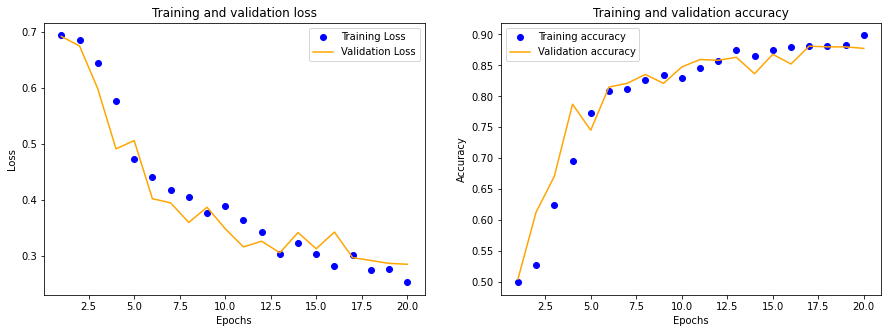

In [27]:
#keras script

import numpy as np
from keras.models import Sequential
from keras import datasets, layers, models

with tf.device('/gpu:0' if DEVICE=='gpu' else '/cpu:0'):
    train_set, val_set, test_set = getPipelines(train_df, val_df, test_df, device=DEVICE)

    # Design model
    input_shape = (H, W, 1) # 128,313,1
    model = Sequential()

    #example sequence: conv, batchNorm, pool

    # Arcitecture
    # model.add(layers.Conv2D(8, (3,3), activation='relu', input_shape=input_shape, padding='same'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Conv2D(16, (5,5), activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Conv2D(32, (5,5), activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Conv2D(64, (5,5), activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(1, activation='sigmoid'))



    # model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPool2D((2,2)))
    # # model.add(layers.Dropout(0.2))
    # # model.add(layers.Conv2D(32, (3,3), activation='relu'))
    # # model.add(layers.MaxPool2D((2,2)))
    # # model.add(layers.Dropout(0.2))
    # model.add(layers.Conv2D(64, (3,3), activation='relu'))
    # model.add(layers.MaxPool2D((2,2)))
    # # model.add(layers.Dropout(0.2))
    # model.add(layers.Flatten())
    # # model.add(layers.Dense(64, activation='relu'))
    # # model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.1))
    # model.add(layers.Dense(1, activation='sigmoid'))



    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # model.add(layers.Conv2D(120, (11,11), strides=(4,4), activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPool2D((3,3), strides=2))
    # model.add(layers.Conv2D(256, (5,5), activation='relu'))
    # model.add(layers.Conv2D(384, (3,3), activation='relu'))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(128, activation='relu'))
    # # model.add(layers.Dropout(0.5))
    # # model.add(layers.Dense(2048, activation='relu'))
    # # model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile Model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='bce', metrics=['accuracy'])
    # model.summary()

    # # Create a TensorBoard callback
    # logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '10,15')

    # Train model on dataset
    history = model.fit(
        x=train_set,
        validation_data=val_set,
        epochs=NUM_EPOCHS,
        steps_per_epoch=int(numTrainBatches*0.9),
        validation_steps=int(numValBatches*0.9),
        # callbacks=tboard_callback
    )

    printMetrics(history)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 311, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 309, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 154, 32)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 152, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 150, 64)       36928     
                                                                 
 batch_normalization (BatchN  (None, 58, 150, 64)      256       
 ormalization)                                          

In [26]:
model.evaluate(test_set, steps=numTestBatches)

9/9 [==============================] - 0s 17ms/step - loss: 0.4495 - accuracy: 0.8194


[0.44952064752578735, 0.8194444179534912]

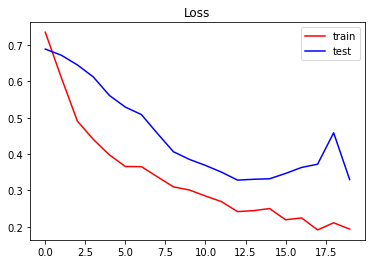

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train', color='red')
plt.plot(history.history['val_loss'], label='test', color='blue')
plt.legend()
plt.show()

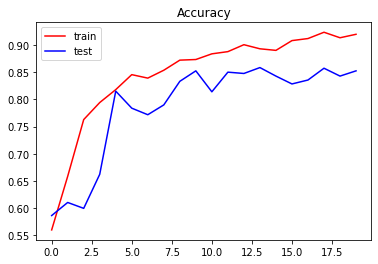

In [18]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train', color='red')
plt.plot(history.history['val_accuracy'], label='test', color='blue')
plt.legend()
plt.show()

In [19]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard


In [20]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 4137063), started 6 days, 6:25:35 ago. (Use '!kill 4137063' to kill it.)